# Markdown - Understanding of Explainability in Time Series Forecasting

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import display, Javascript

import random
random.seed(1)

The code below fetches historical stock data for a specified stock symbol (`NVDA` in this case) using the `yfinance` library.

In [4]:
# Specify stock symbol and date range
stock_symbol = 'NVDA'
# Fetch historical stock data
stock_data = yf.download(stock_symbol,  period="1y")

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data.dropna(inplace=True)

In [6]:
# Display the initial rows of the dataset
print(stock_data.head()) 

Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2024-01-18  57.090813  57.583673  56.091096  57.243769  491650000
2024-01-19  59.474140  59.483136  57.208780  57.972563  543501000
2024-01-22  59.637096  60.313907  59.053262  60.031985  452955000
2024-01-23  59.856033  59.893022  58.568396  59.553118  294654000
2024-01-24  61.344608  62.831186  59.921012  60.286910  560271000


We want to make a simple dataframe where we can compare different time points against each other by having multiple columns (features or "lags") which consists of t-1, t-2 etc. I made a function where I could provide the number of lags we want to encapsulate it will make the defined matrix necessary.

The `create_lag_features` function generates lagged features for time series data, which are crucial for tasks like forecasting or regression. It takes a DataFrame data with a `Close` column and an integer `lags` indicating the number of lagged steps to include. The function sorts the data in descending order (most recent data first) and initializes a new DataFrame, where the current values (t) are directly assigned from the Close column. In the loop, for each lag `i` from 1 to `lags`, it creates a new column `t-i` using `data['Close'].shift(-i)`. The negative shift ensures that earlier values (lagged values) move upward to align with the current index, consistent with the descending order. For example, `t-1` represents the value one step before, and `t-2` represents the value two steps before. Once all lagged features are created, rows where any of the lagged columns contain `NaN` (due to insufficient earlier data) are dropped, ensuring the output DataFrame is clean and ready for modeling. This setup allows the inclusion of historical values as predictors for future predictions.

In [9]:
def create_lag_features(data, lags):
    """
    Create lag features for the given time series data.
    Parameters:
        data (pd.DataFrame): Original stock data
        lags (int): Number of lag days to include
    Returns:
        pd.DataFrame: DataFrame with lag features
    """

    # Sort data by date in descending order
    data = data.sort_index(ascending=False)
    
    # Create lagged features
    lagged_data = pd.DataFrame(index=data.index)
    lagged_data['t'] = data['Close']
    for i in range(1, lags + 1):
        lagged_data[f't-{i}'] = data['Close'].shift(-i)  # Use negative shift for descending order

    # Drop rows where all lagged values are NaN
    lagged_data.dropna(subset=[f't-{i}' for i in range(1, lags + 1)], inplace=True)

    return lagged_data

Let's take some examples to view how the matrices are constructed with the data so we can see whether it is done correctly.

In [11]:
create_lag_features(stock_data, 2)

,t,t-1,t-2
Date,,,
2025-01-17,137.710007,133.570007,136.240005
2025-01-16,133.570007,136.240005,131.759995
2025-01-15,136.240005,131.759995,133.229996
2025-01-14,131.759995,133.229996,135.910004
2025-01-13,133.229996,135.910004,140.110001
...,...,...,...
2024-01-26,61.013702,61.599533,61.344608
2024-01-25,61.599533,61.344608,59.856033
2024-01-24,61.344608,59.856033,59.637096


In [12]:
create_lag_features(stock_data, 6)

,t,t-1,t-2,t-3,t-4,t-5,t-6
Date,,,,,,,
2025-01-17,137.710007,133.570007,136.240005,131.759995,133.229996,135.910004,140.110001
2025-01-16,133.570007,136.240005,131.759995,133.229996,135.910004,140.110001,140.139999
2025-01-15,136.240005,131.759995,133.229996,135.910004,140.110001,140.139999,149.429993
2025-01-14,131.759995,133.229996,135.910004,140.110001,140.139999,149.429993,144.470001
2025-01-13,133.229996,135.910004,140.110001,140.139999,149.429993,144.470001,138.309998
...,...,...,...,...,...,...,...
2024-02-01,63.009136,61.509563,62.756203,62.447296,61.013702,61.599533,61.344608
2024-01-31,61.509563,62.756203,62.447296,61.013702,61.599533,61.344608,59.856033
2024-01-30,62.756203,62.447296,61.013702,61.599533,61.344608,59.856033,59.637096


In this case, `t` can be seen as the **`y` (target / output)**, where the model is trained towards. `t-1` ... `t-6` are the **`X's` (inputs)** of the model. These will be used to train the model and identify relationships. Neural networks would process this data as follows:

- **Feature Input**: Each row (a single observation) is treated as an input vector where `t`, `t-1`, ..., `t-6` are features. For a fully connected network, all features are considered together to capture patterns.
- **Learning Temporal Patterns**: Neural networks, especially recurrent neural networks (RNNs) or long short-term memory (LSTM) networks, are well-suited for sequential data. These architectures can model dependencies across time steps (lags), learning patterns like momentum, reversals, or stagnation over time.
- **Weights and Relationships**: Neural networks assign weights to each lagged feature, indicating its importance for prediction (For example, if `t-1` (the most recent lag) consistently has a stronger relationship with `t` than `t-6`, the model will learn to emphasize `t-1` more.). 
- **Feature Interactions**: Neural networks can capture nonlinear interactions between the features. For instance, the combined influence of `t-2` and `t-3` may indicate a certain price movement, even if those lags individually don't.

Before moving into neural nets, let's start by making a simple linear regression on the created data to visualize dependencies in the data.

### Model: **Linear Regression**

Linear regression models the relationship between the **target variable (`y`)** and the **input features (`X`)** by fitting a straight-line equation:

$$
y = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \cdots + \beta_n \cdot x_n
$$

Where:
- \( $y$ \): Target variable (in this case, column `t`).
- \( $x_1$, $x_2$, ..., $x_n$ \): Input features (e.g., `t-1`, `t-2`, ..., `t-n`).
- \( $\beta_0$ \): Intercept (constant term).
- \( $\beta_1$, $\beta_2$, ..., $\beta_n$ \): Coefficients or weights for the input features.

The goal of linear regression is to find the coefficients \( $\beta_1$, $\beta_2$, ..., $\beta_n$ \) and the intercept \( $\beta_0$ \) that minimize the difference between the actual values (`y`) and the predicted values ($`^\hat{y}`$).

This is achieved using the **Ordinary Least Squares (OLS)** method, which minimizes the **Sum of Squared Errors (SSE)**:

$$
SSE = \sum_{i=1}^m (y_i - \hat{y}_i)^2
$$

Where:
- \( $y_i$ \): Actual value of the target for the \(i\)-th observation.
- \( $\hat{y}_i$ \): Predicted value for the \(i\)-th observation, calculated as:
  $$
  \hat{y}_i = \beta_0 + \beta_1 \cdot x_{i1} + \beta_2 \cdot x_{i2} + \cdots + \beta_n \cdot x_{in}
  $$

Linear regression solves this problem using matrix algebra. The formula for calculating the weights is:

$$
\beta = (X^T X)^{-1} X^T y
$$

Here:
- \( $X$ \): Matrix of input features (e.g., `t-1`, `t-2`, ..., `t-n`).
- \( $y$ \): Vector of the target variable (e.g., `t`).
- \( $\beta$ \): Vector of coefficients (weights) that minimize the SSE.


#### Code

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def linear_regression_analysis(stock_data, lags_list, show_details=True):
    """
    Perform linear regression analysis on lagged stock data, evaluate the model, and plot results.

    Parameters:
    stock_data (DataFrame): A pandas DataFrame with stock data.
    lags_list (list): A list of integers specifying the number of lags for each regression.
    show_details (bool): Whether to show formulas, weights, and evaluation metrics. Default is True.

    Returns:
    None
    """
    for lags in lags_list:
        lagged_stock_data = create_lag_features(stock_data, lags)

        # Prepare data for regression
        X = lagged_stock_data.iloc[:, 1:]  # All columns except 't' as features
        y = lagged_stock_data['t']  # 't' as the target variable

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Fit the linear regression model on the training data
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)

        # Extract coefficients and intercept
        intercept = lr_model.intercept_
        coefficients = lr_model.coef_

        # Construct the regression formula
        formula = f"t = {intercept:.2f}"
        for i, coef in enumerate(coefficients, start=1):
            formula += f" + ({coef:.2f} * t-{i})"

        if show_details:
            # Display the regression formula and feature weights
            print(f"\nLinear Regression with {lags} Lags:")
            print("Linear Regression Formula:")
            print(formula)

            print("\nIntercept:")
            print(f"{intercept:.2f}")

            print("\nFeature Weights:")
            for feature, coef in zip(X.columns, coefficients):
                print(f"{feature}: {coef:.2f}")

        # Make predictions on the testing set
        y_pred_lr = lr_model.predict(X_test)

        # Evaluate the model
        mae = mean_absolute_error(y_test, y_pred_lr)
        mse = mean_squared_error(y_test, y_pred_lr)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred_lr)

        if show_details:
            print("\nLinear Regression Model Evaluation (Test Data):")
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Mean Squared Error (MSE): {mse:.2f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
            print(f"R² Score: {r2:.2f}")

        # Create a DataFrame to compare actual and predicted values for the test set
        comparison_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr}, index=y_test.index)

        # Sort the DataFrame by index to maintain the correct order of dates
        comparison_lr.sort_index(inplace=True)

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(comparison_lr.index, comparison_lr['Actual'], label='Actual', linestyle='-')
        plt.plot(comparison_lr.index, comparison_lr['Predicted'], label='Predicted', linestyle='-', color='orange')

        # Add labels, title, and legend
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('t (Target)', fontsize=12)
        plt.title(f'Linear Regression: Actual vs Predicted Values (Lags = {lags})', fontsize=14)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Display the plot
        plt.show()

### Model: **Neural Networks**

A neural network models the relationship between the **target variable (`y`)** and the **input features (`X`)** by simulating a network of interconnected neurons across multiple layers. Each neuron computes a weighted sum of inputs, applies a non-linear activation function, and passes the result to the next layer.

- **Input Layer**: Represents the input features (e.g., `t-1`, `t-2`, ..., `t-n`).

- **Hidden Layers**: Layers of neurons where each neuron computes:
   $$
   h_j = f\left(\sum_{i=1}^n w_{ij}x_i + b_j\right)
   $$
   - \( $h_j$ \): Output of neuron \( j \) in the hidden layer.
   - \( $w_{ij}$ \): Weight connecting input \( i \) to neuron \( j \).
   - \( $b_j$ \): Bias term for neuron \( j \).
   - \( $f$ \): Activation function (in this case, logistic/sigmoid).

- **Output Layer**: Produces the final prediction:
   $$
   \hat{y} = \sum_{j=1}^m w_{j}h_j + b
   $$
   - \( $\hat{y}$ \): Predicted target value.
   - \( $m$ \): Number of neurons in the last hidden layer.
   - \( $w_j$ \): Weight for neuron \( j \) in the hidden layer.

- **Hidden Layer Size**: The architecture uses a single hidden layer with 100 neurons. The size controls the model's capacity to learn patterns.
- **Activation Function**: The sigmoid (logistic) activation maps outputs to a range [0, 1], allowing the network to model non-linear relationships.
- **Optimization**: The network minimizes the **Mean Squared Error (MSE)** using backpropagation and gradient descent to adjust weights.

The network learns by iteratively updating weights to minimize the error between actual \( y \) and predicted \( \hat{y} \):
1. **Forward Pass**: Computes predictions by propagating inputs through the network.
2. **Loss Calculation**: Measures the error (e.g., MSE).
3. **Backward Pass**: Uses backpropagation to compute gradients of the loss with respect to weights.
4. **Weight Update**: Adjusts weights using gradient descent.

#### Code

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def neural_network_regression_analysis(stock_data, lags_list, show_details=True):
    """
    Perform neural network regression analysis on lagged stock data, evaluate the model, and plot results.

    Parameters:
    stock_data (DataFrame): A pandas DataFrame with stock data.
    lags_list (list): A list of integers specifying the number of lags for each regression.
    show_details (bool): Whether to show evaluation metrics. Default is True.

    Returns:
    None
    """
    for lags in lags_list:
        lagged_stock_data = create_lag_features(stock_data, lags)

        # Prepare data for regression
        X = lagged_stock_data.iloc[:, 1:]  # All columns except 't' as features
        y = lagged_stock_data['t']  # 't' as the target variable

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Normalize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Define the neural network model
        nn_model = MLPRegressor(
            hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
            activation='logistic',      # Sigmoid activation function
            max_iter=10000,             # Increase max iterations for better convergence
            random_state=42             # For reproducibility
        )

        # Fit the neural network model on the training data
        nn_model.fit(X_train_scaled, y_train)

        # Predict values for the test set
        y_pred_nn = nn_model.predict(X_test_scaled)

        # Evaluate the model
        mae = mean_absolute_error(y_test, y_pred_nn)
        mse = mean_squared_error(y_test, y_pred_nn)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred_nn)

        if show_details:
            print(f"\nNeural Network Model Evaluation (Lags = {lags}):")
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Mean Squared Error (MSE): {mse:.2f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
            print(f"R² Score: {r2:.2f}")

        # Create a DataFrame to compare actual and predicted values for the test set
        comparison_nn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_nn}, index=y_test.index)

        # Sort the DataFrame by index to maintain the correct order of dates
        comparison_nn.sort_index(inplace=True)

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(comparison_nn.index, comparison_nn['Actual'], label='Actual', linestyle='-')
        plt.plot(comparison_nn.index, comparison_nn['Predicted'], label='Predicted', linestyle='-', color='red')

        # Add labels, title, and legend
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('t (Target)', fontsize=12)
        plt.title(f'Neural Network: Actual vs Predicted Values (Lags = {lags})', fontsize=14)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Display the plot
        plt.show()

## Analysis 

**(Change in # Lags)**


Linear Regression with 1 Lags:
Linear Regression Formula:
t = 2.84 + (0.98 * t-1)

Intercept:
2.84

Feature Weights:
t-1: 0.98

Linear Regression Model Evaluation (Test Data):
Mean Absolute Error (MAE): 2.46
Mean Squared Error (MSE): 9.70
Root Mean Squared Error (RMSE): 3.11
R² Score: 0.98


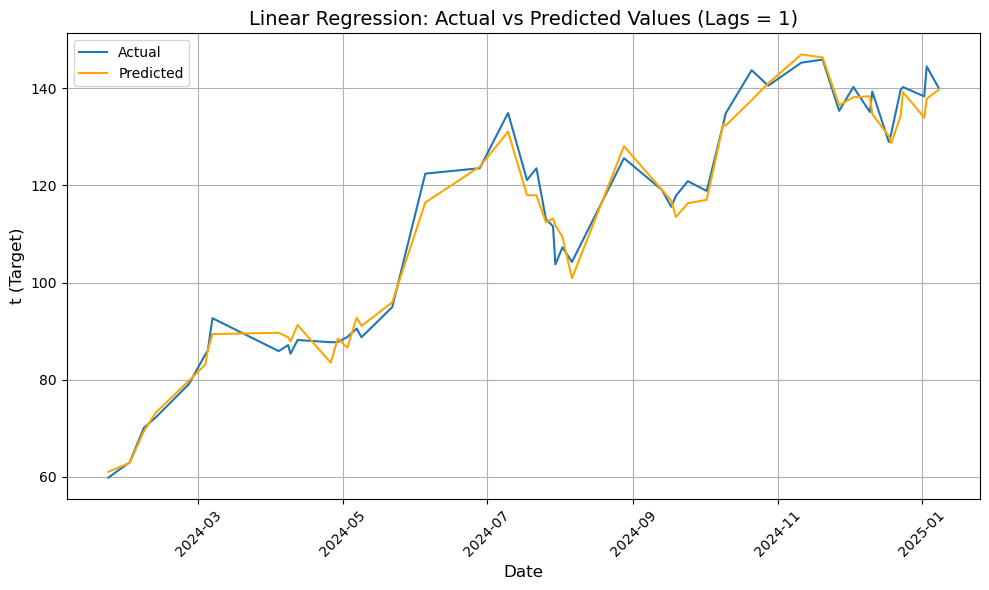


Linear Regression with 10 Lags:
Linear Regression Formula:
t = 2.91 + (0.93 * t-1) + (0.09 * t-2) + (-0.14 * t-3) + (0.12 * t-4) + (-0.10 * t-5) + (0.09 * t-6) + (-0.05 * t-7) + (0.05 * t-8) + (0.09 * t-9) + (-0.10 * t-10)

Intercept:
2.91

Feature Weights:
t-1: 0.93
t-2: 0.09
t-3: -0.14
t-4: 0.12
t-5: -0.10
t-6: 0.09
t-7: -0.05
t-8: 0.05
t-9: 0.09
t-10: -0.10

Linear Regression Model Evaluation (Test Data):
Mean Absolute Error (MAE): 3.08
Mean Squared Error (MSE): 16.57
Root Mean Squared Error (RMSE): 4.07
R² Score: 0.97


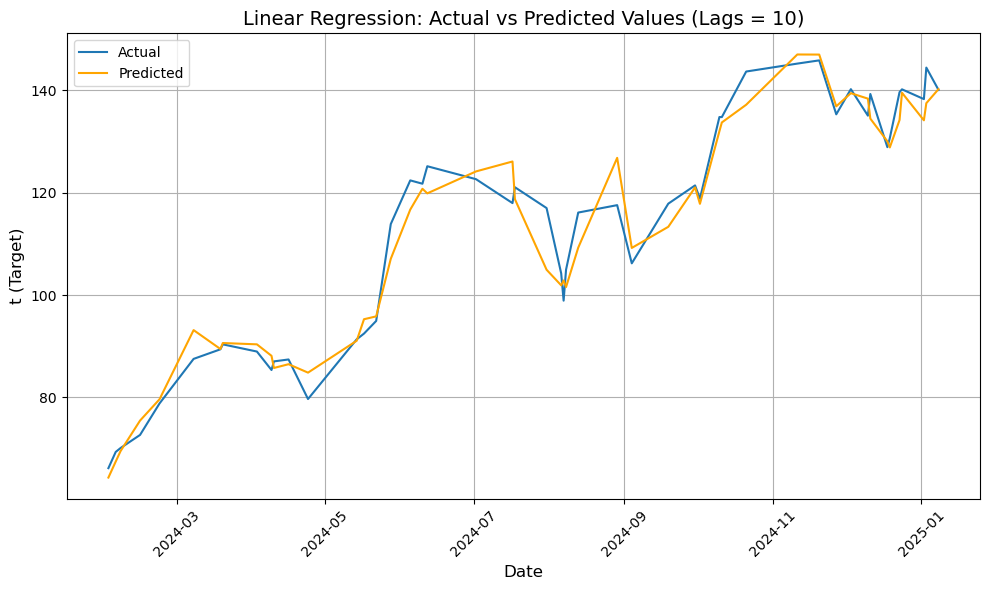


Linear Regression with 100 Lags:
Linear Regression Formula:
t = 8.37 + (0.36 * t-1) + (0.89 * t-2) + (-0.54 * t-3) + (0.28 * t-4) + (-0.27 * t-5) + (0.07 * t-6) + (0.03 * t-7) + (-0.07 * t-8) + (0.05 * t-9) + (0.32 * t-10) + (-0.17 * t-11) + (-0.04 * t-12) + (0.34 * t-13) + (-0.42 * t-14) + (-0.33 * t-15) + (0.51 * t-16) + (0.27 * t-17) + (-0.58 * t-18) + (0.19 * t-19) + (0.08 * t-20) + (0.04 * t-21) + (0.09 * t-22) + (-0.01 * t-23) + (0.09 * t-24) + (0.01 * t-25) + (-0.19 * t-26) + (0.01 * t-27) + (-0.45 * t-28) + (0.89 * t-29) + (-0.91 * t-30) + (0.66 * t-31) + (-0.12 * t-32) + (-0.69 * t-33) + (0.74 * t-34) + (-0.46 * t-35) + (0.71 * t-36) + (-0.06 * t-37) + (-0.80 * t-38) + (0.41 * t-39) + (-0.46 * t-40) + (0.04 * t-41) + (-0.44 * t-42) + (1.01 * t-43) + (0.12 * t-44) + (-0.50 * t-45) + (0.39 * t-46) + (-0.22 * t-47) + (-0.09 * t-48) + (0.44 * t-49) + (-0.26 * t-50) + (0.50 * t-51) + (-0.53 * t-52) + (0.09 * t-53) + (-0.30 * t-54) + (0.16 * t-55) + (-0.31 * t-56) + (-0.02 * t-57) 

/var/folders/q3/j_2_rkx148lffppwjbq3_rt80000gq/T/ipykernel_81397/2564743368.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[f't-{i}'] = data['Close'].shift(-i)  # Use negative shift for descending order


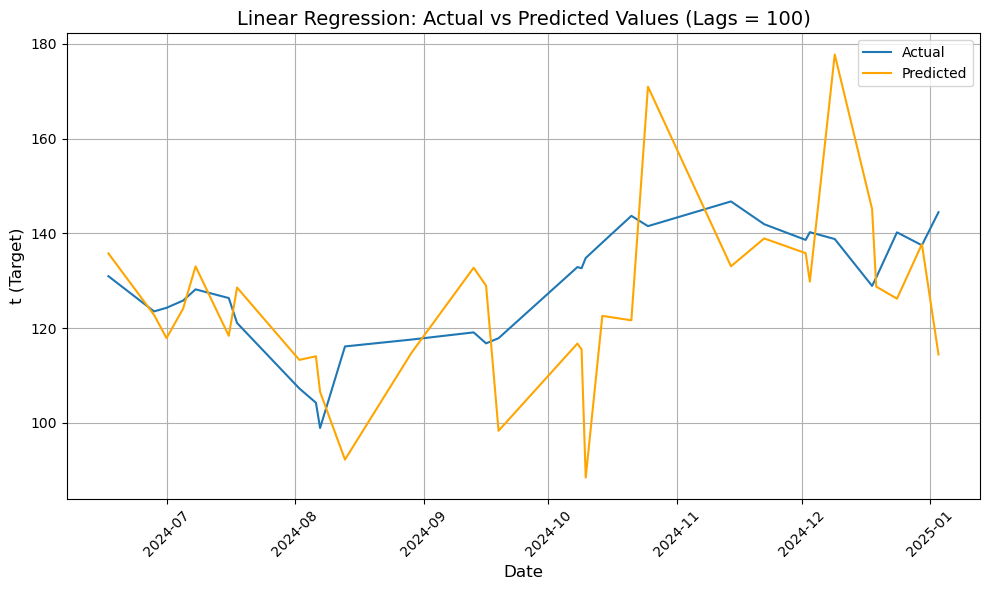

In [23]:
linear_regression_analysis(stock_data, lags_list=[1, 10, 100], show_details=True)


Neural Network Model Evaluation (Lags = 1):
Mean Absolute Error (MAE): 2.48
Mean Squared Error (MSE): 9.48
Root Mean Squared Error (RMSE): 3.08
R² Score: 0.98


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


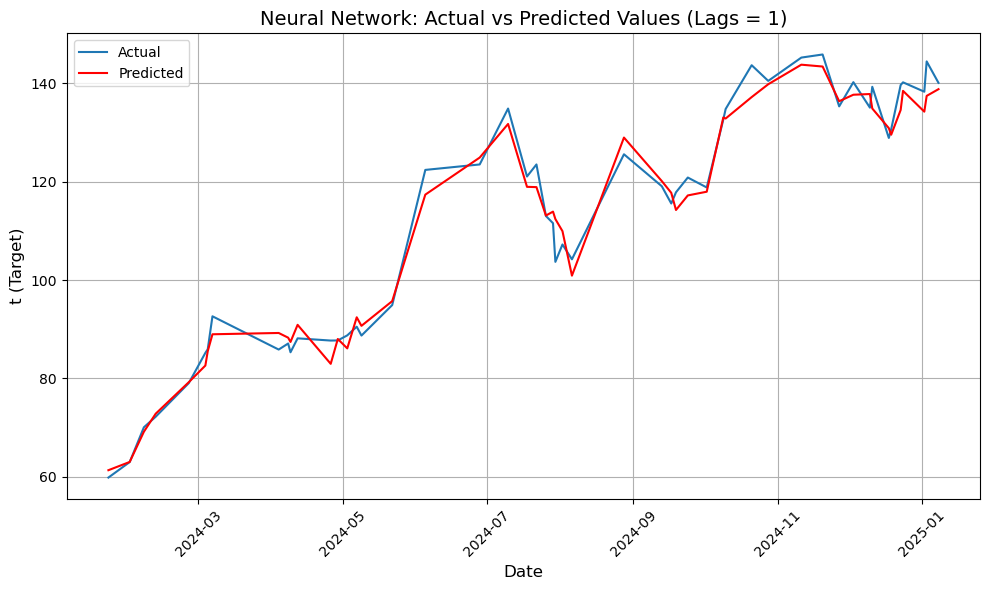


Neural Network Model Evaluation (Lags = 10):
Mean Absolute Error (MAE): 3.20
Mean Squared Error (MSE): 19.19
Root Mean Squared Error (RMSE): 4.38
R² Score: 0.97


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


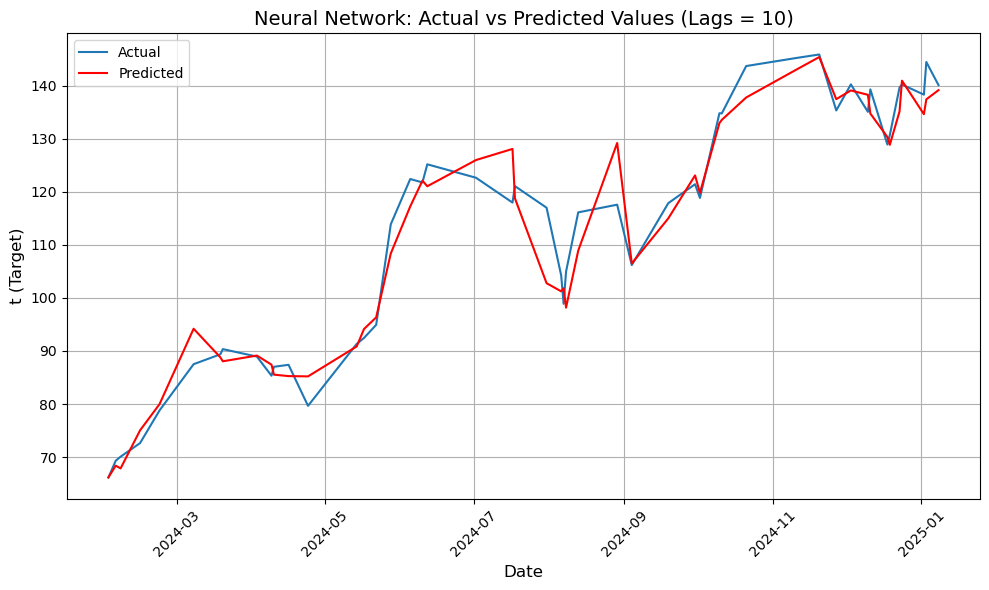

/var/folders/q3/j_2_rkx148lffppwjbq3_rt80000gq/T/ipykernel_81397/2564743368.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[f't-{i}'] = data['Close'].shift(-i)  # Use negative shift for descending order



Neural Network Model Evaluation (Lags = 100):
Mean Absolute Error (MAE): 2.67
Mean Squared Error (MSE): 12.18
Root Mean Squared Error (RMSE): 3.49
R² Score: 0.92


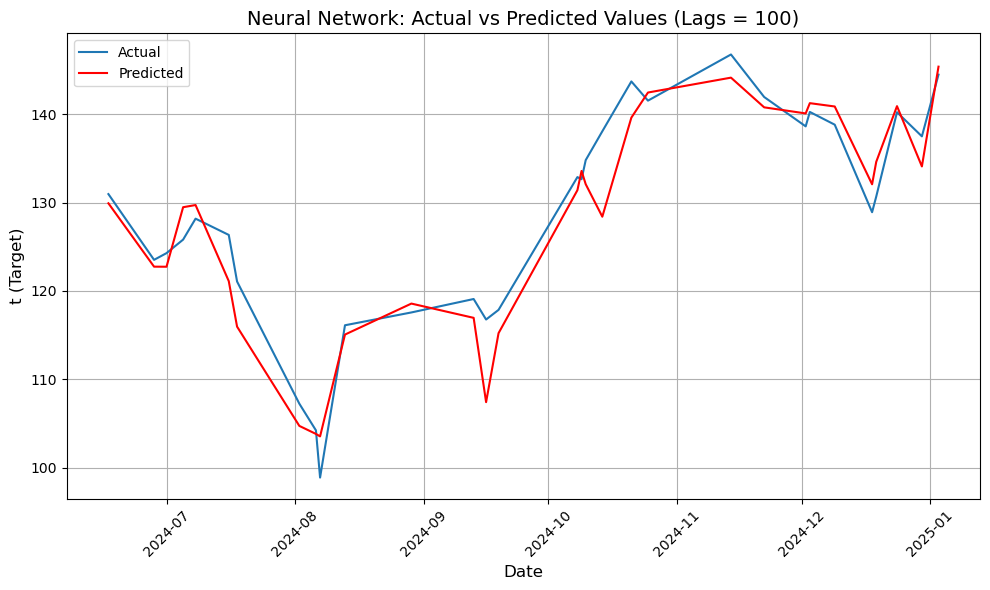

In [24]:
neural_network_regression_analysis(stock_data, lags_list=[1, 10, 100], show_details=True)

$R^2$ values are this high due to the fact that we assume a a 6-time lag for every new point we assume in the next stage `t`, but afterwards for the next `t`, we reset this prediction back to its original state by reassessing the previous six lags from a different time perspective.

In [26]:
import shap

def neural_network_regression_analysis_xai(stock_data, lags_list, show_details=True):
    for lags in lags_list:
        lagged_stock_data = create_lag_features(stock_data, lags)
        X = lagged_stock_data.iloc[:, 1:]
        y = lagged_stock_data['t']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        nn_model = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', max_iter=10000, random_state=42)
        nn_model.fit(X_train_scaled, y_train)

        y_pred_nn = nn_model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred_nn)
        mse = mean_squared_error(y_test, y_pred_nn)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred_nn)

        if show_details:
            print(f"\nEvaluation Metrics (Lags = {lags}):")
            print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

        # SHAP Analysis
        print(f"\nSHAP Analysis for Lags = {lags}...")
        explainer = shap.KernelExplainer(nn_model.predict, X_train_scaled)
        shap_values = explainer.shap_values(X_test_scaled, nsamples=100)

        # Global Bar Plot
        print(f"\nGlobal SHAP Feature Importance (Bar Plot) for Lags = {lags}:")
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

        # Optional: SHAP Summary Plot
        shap.summary_plot(shap_values, X_test, feature_names=X.columns)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
Using 199 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Evaluation Metrics (Lags = 3):
MAE: 2.90, MSE: 14.02, RMSE: 3.74, R²: 0.98

SHAP Analysis for Lags = 3...


  0%|          | 0/50 [00:00<?, ?it/s]


Global SHAP Feature Importance (Bar Plot) for Lags = 3:


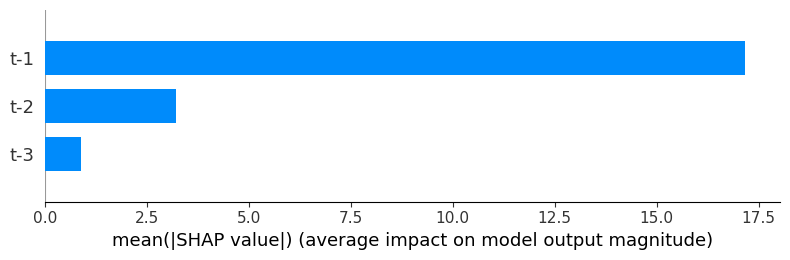

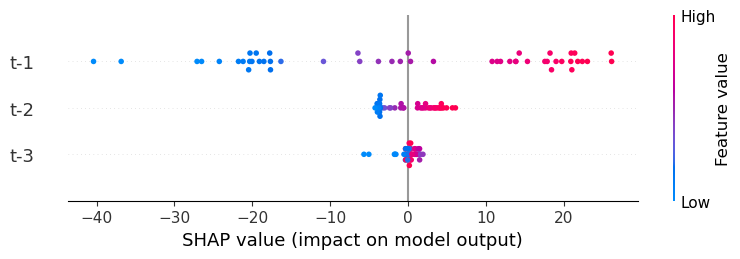

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
Using 197 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Evaluation Metrics (Lags = 5):
MAE: 2.55, MSE: 12.25, RMSE: 3.50, R²: 0.98

SHAP Analysis for Lags = 5...


  0%|          | 0/50 [00:00<?, ?it/s]


Global SHAP Feature Importance (Bar Plot) for Lags = 5:


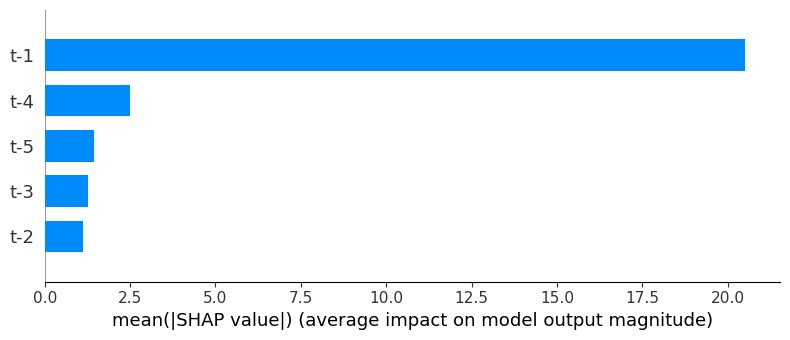

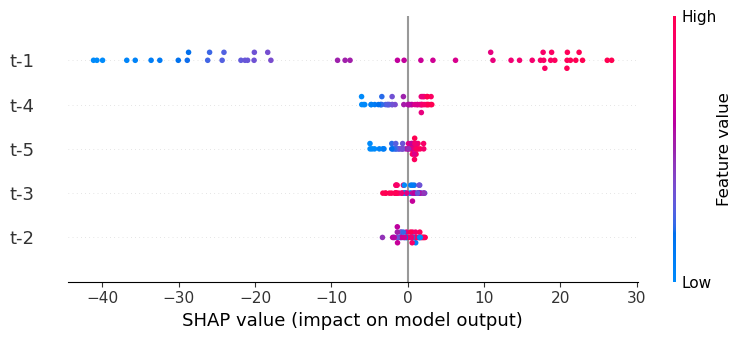

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
Using 196 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Evaluation Metrics (Lags = 7):
MAE: 3.01, MSE: 15.59, RMSE: 3.95, R²: 0.97

SHAP Analysis for Lags = 7...


  0%|          | 0/49 [00:00<?, ?it/s]


Global SHAP Feature Importance (Bar Plot) for Lags = 7:


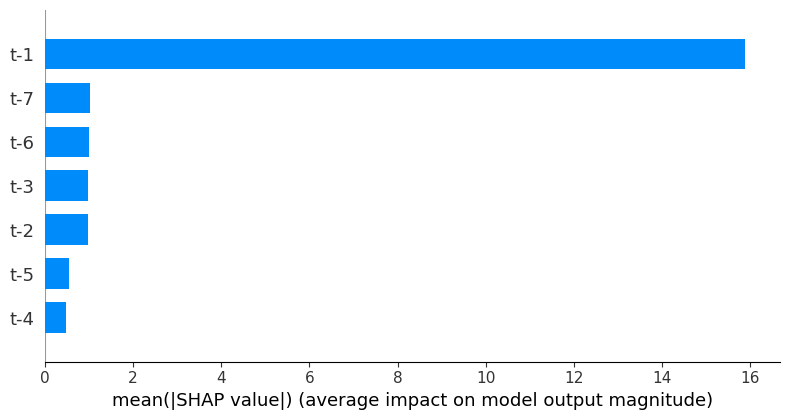

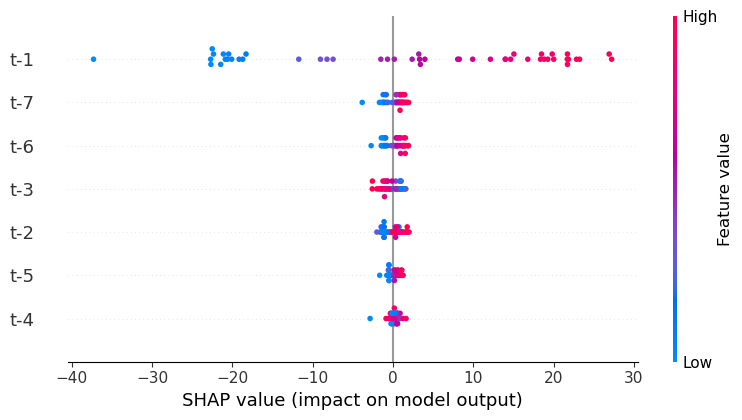

In [27]:
neural_network_regression_analysis_xai(stock_data, [3, 5, 7])

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Function to calculate Linear Parameter Data (LPD)
def calculate_lpd_lr(inputs, outputs):
    """
    Calculate the Linear Parameter Data (LPD) for given inputs and outputs.

    Parameters:
        inputs (np.ndarray): Input features (lagged features), shape (n_samples, n_features).
        outputs (np.ndarray): Output values, shape (n_samples,).

    Returns:
        pd.DataFrame: LPD matrix containing intercept and weights for each time step.
    """
    # Fit linear regression model across all data
    model = LinearRegression()
    model.fit(inputs, outputs)

    # Extract intercept and coefficients
    intercept = model.intercept_
    weights = model.coef_

    # Apply model to each time step to compute weights dynamically
    lpd_data = []
    for i in range(len(outputs)):
        x = inputs[i]
        intercept_i = intercept
        weights_i = weights * x
        lpd_data.append([intercept_i] + weights_i.tolist())

    # Convert to DataFrame
    columns = ["Intercept"] + [f"w_{i+1}" for i in range(inputs.shape[1])]
    lpd_df = pd.DataFrame(lpd_data, columns=columns)
    return lpd_df

In [29]:
lagged_data = create_lag_features(stock_data, 6)
lags = 6

inputs = lagged_data[[f't-{i}' for i in range(1, lags + 1)]].values # all t-i (X) values
outputs = lagged_data['t'].values # all t (y) values

# Calculate LPD matrix
lpd_df = calculate_lpd_lr(inputs, outputs)
lpd_df.index = lagged_data.index
lpd_df

,Intercept,w_1,w_2,w_3,w_4,w_5,w_6
Date,,,,,,,
2025-01-17,2.41585,121.354374,18.537084,-15.919967,4.394285,-12.827773,16.739708
2025-01-16,2.41585,123.780187,17.927524,-16.097580,4.482679,-13.224186,16.743293
2025-01-15,2.41585,119.709895,18.127536,-16.421393,4.621206,-13.227018,17.853219
2025-01-14,2.41585,121.045458,18.492183,-16.928860,4.622195,-14.103848,17.260622
2025-01-13,2.41585,123.480366,19.063643,-16.932485,4.928604,-13.635702,16.524652
...,...,...,...,...,...,...,...
2024-02-01,2.41585,55.884212,8.538733,-7.545225,2.012397,-5.814030,7.329176
2024-01-31,2.41585,57.016839,8.496702,-7.372011,2.031719,-5.789969,7.151328
2024-01-30,2.41585,56.736184,8.301645,-7.442794,2.023311,-5.649471,7.125170


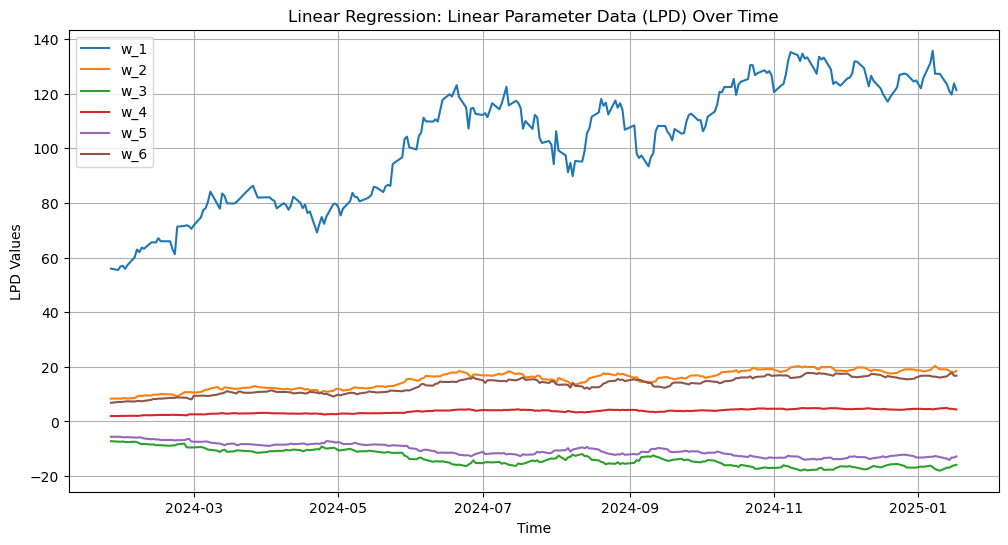

In [30]:
# Plot LPD over time (exclude intercept)
plt.figure(figsize=(12, 6))
for col in lpd_df.columns[1:]:  # Skip intercept
    plt.plot(lpd_df.index, lpd_df[col], label=col)

plt.title("Linear Regression: Linear Parameter Data (LPD) Over Time")
plt.xlabel("Time")
plt.ylabel("LPD Values")
plt.legend()
plt.grid()
plt.show()

 **Positive LPD Value**
- A positive LPD value for a lagged feature (e.g., $w_1, w_2, \\dots$) indicates:
  - As the corresponding lagged feature increases, the output (e.g., stock price or target variable) is expected to **increase**.
  - It signifies a **positive correlation** between the lagged feature and the output at a specific time step.

*Example*:
If $w_1 > 0$, it means that higher values of $t-1$ (previous day's stock price) tend to result in higher output values (e.g., today's stock price)

**Negative LPD Value**
- A negative LPD value for a lagged feature indicates:
  - As the corresponding lagged feature increases, the output is expected to **decrease**.
  - It signifies a **negative correlation** between the lagged feature and the output at a specific time step.

*Example*:
If $w_2 < 0$, it means that higher values of $t-2$ (stock price two days ago) are associated with lower output values (e.g., today's stock price).


In [61]:
def calculate_lpd_nn(inputs, outputs):
    """
    Calculate the Linear Parameter Data (LPD) for given inputs and outputs using an MLPRegressor.

    Parameters:
        inputs (np.ndarray): Input features (lagged features), shape (n_samples, n_features).
        outputs (np.ndarray): Output values, shape (n_samples,).

    Returns:
        pd.DataFrame: LPD matrix containing intercept and weights for each time step.
    """
    # Define and train the MLP Regressor
    mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', max_iter=1000, random_state=42)
    mlp.fit(inputs, outputs)

    # Extract coefficients (weights) and intercepts
    hidden_layer_weights = mlp.coefs_[0]  # Weights from input to hidden layer
    output_layer_weights = mlp.coefs_[1]  # Weights from hidden layer to output
    hidden_layer_biases = mlp.intercepts_[0]  # Biases for hidden layer
    output_layer_bias = mlp.intercepts_[1]  # Bias for output layer

    # Calculate the LPD per time stepp
    lpd_data = []
    for i in range(len(outputs)):
        x = inputs[i]  # Create inputs per "current time step"

        # Calculate hidden layer activations
        hidden_activations = np.dot(x, hidden_layer_weights) + hidden_layer_biases
        hidden_activations = 1 / (1 + np.power(hidden_activations, 2))  # using an Arctan-like activation derivative (ChatGPT proposal)

        # Calculate the output
        predicted_output = np.dot(hidden_activations, output_layer_weights) + output_layer_bias

        # Calculate "contributions" (partial derivatives * inputs)
        contributions = output_layer_weights * hidden_activations
        intercept = predicted_output - np.sum(contributions)

        # Combine intercept and contributions
        lpd_data.append([intercept] + contributions.tolist())

    # Convert to DataFrame
    columns = ["Intercept"] + [f"Neuron_{i+1}" for i in range(len(output_layer_weights))]
    lpd_df = pd.DataFrame(lpd_data, columns=columns)
    return lpd_df

**How lags are handled:**

Inputs (inputs):
- The inputs parameter represents all lagged features, with a shape of (n_samples, n_features).
Each column of inputs corresponds to one specific lag. Example: If there are 6 lags, the first 6 columns of inputs represent the lagged features.

Contributions:
- The calculation of hidden_activations (np.dot(x, hidden_layer_weights)) combines all lagged features. Sensitivities are then averaged across all lags in the final plot.

# Assessing Neural Net per Lag 

In [64]:
def calculate_lpd_nn_by_lag(inputs, outputs):
    """
    Calculate the Linear Parameter Data (LPD) for each lag separately.

    Parameters:
        inputs (np.ndarray): Input features (lagged features), shape (n_samples, n_features).
        outputs (np.ndarray): Output values, shape (n_samples,).

    Returns:
        pd.DataFrame: LPD matrix containing contributions for each lag over time.
    """
    # Define and train the MLP Regressor
    mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', max_iter=1000, random_state=42)
    mlp.fit(inputs, outputs)

    # Extract coefficients (weights) and intercepts
    hidden_layer_weights = mlp.coefs_[0]  # Weights from input to hidden layer
    output_layer_weights = mlp.coefs_[1]  # Weights from hidden layer to output
    hidden_layer_biases = mlp.intercepts_[0]  # Biases for hidden layer
    output_layer_bias = mlp.intercepts_[1]  # Bias for output layer

    # Calculate the LPD for each time step
    lpd_data = []
    for i in range(len(outputs)):
        x = inputs[i]  # Input for the current time step

        # Calculate hidden layer activations
        hidden_activations = np.dot(x, hidden_layer_weights) + hidden_layer_biases
        hidden_activations = 1 / (1 + np.power(hidden_activations, 2))  # Arctan-like activation derivative

        # Calculate output
        predicted_output = np.dot(hidden_activations, output_layer_weights) + output_layer_bias

        # Calculate contributions for each lag
        lag_contributions = []
        for lag in range(inputs.shape[1]):  # Loop over each lag
            lag_weight = hidden_layer_weights[lag, :]  # Weights for this lag to hidden layer
            lag_contribution = np.dot(lag_weight, hidden_activations)
            lag_contributions.append(lag_contribution)

        # Combine intercept and lag contributions
        intercept = predicted_output - np.sum(lag_contributions)
        lpd_data.append([intercept] + lag_contributions)

    # Convert to DataFrame
    columns = ["Intercept"] + [f"Lag_{i+1}" for i in range(inputs.shape[1])]
    lpd_df = pd.DataFrame(lpd_data, columns=columns)
    return lpd_df


In [95]:
# Call the function
lpd_df_by_lag = calculate_lpd_nn_by_lag(inputs, outputs)

print(lpd_df_by_lag)

                Intercept     Lag_1     Lag_2     Lag_3     Lag_4     Lag_5  \
0     [2.877411247631912] -0.008547 -0.006289  0.017644  0.008834  0.006133   
1    [2.8472560285080286] -0.009749  0.001676  0.015473  0.007981  0.002328   
2    [2.7496991676485405] -0.003944  0.005998  0.011816  0.005799  0.006011   
3    [2.7559164200890787]  0.000173  0.002214  0.009350  0.008742 -0.006147   
4    [2.8248893738014944] -0.000796 -0.009565  0.020010 -0.007858  0.001478   
..                    ...       ...       ...       ...       ...       ...   
241   [9.223944737956572] -0.018533 -0.051137  0.044539  0.029195  0.035230   
242   [9.635810882407597] -0.038540 -0.064368  0.085473 -0.002340  0.036678   
243   [9.639220717942857] -0.043027 -0.038523  0.058026  0.001364  0.058131   
244   [9.737496758698425] -0.028471 -0.056235  0.047878  0.025168  0.048542   
245  [10.490018528512401] -0.044152 -0.084273  0.089127  0.000921  0.037091   

        Lag_6  
0    0.023619  
1    0.022956  
2  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [105]:
lag_1_timestamp_1 = lpd_df_by_lag.loc[1, "Lag_1"]
print(lag_1_timestamp_1)

-0.009748773102949004


Text(0, 0.5, 'Sensitivity')

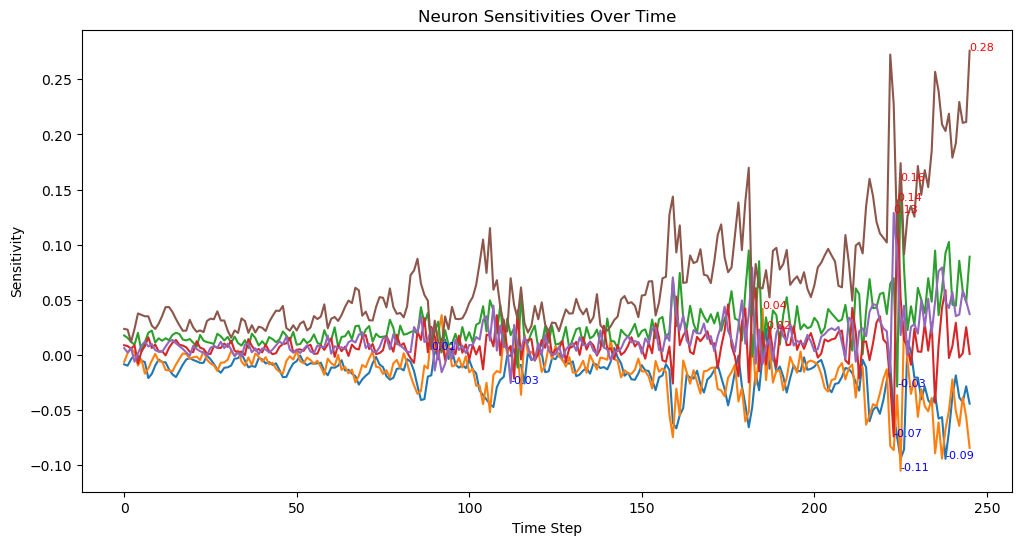

In [75]:
# Extract sensitivity data for neurons (excluding the intercept)
neuron_sensitivities = lpd_df_by_lag.drop(columns=["Intercept"])

neuron_sensitivities = neuron_sensitivities.map(lambda x: x[0] if isinstance(x, list) else x)

# Plot each neuron's sensitivity over time
plt.figure(figsize=(12, 6))
for neuron in neuron_sensitivities.columns:
    plt.plot(neuron_sensitivities.index, neuron_sensitivities[neuron], label=neuron)

    # Get the highest and lowest sensitivity values
    max_idx = neuron_sensitivities[neuron].idxmax()
    min_idx = neuron_sensitivities[neuron].idxmin()
    max_val = neuron_sensitivities[neuron].max()
    min_val = neuron_sensitivities[neuron].min()
    
    # Add labels for the highest and lowest points
    plt.text(max_idx, max_val, f"{max_val:.2f}", color="red", fontsize=8)
    plt.text(min_idx, min_val, f"{min_val:.2f}", color="blue", fontsize=8)

# Customize the plot
plt.title("Neuron Sensitivities Over Time")
plt.xlabel("Time Step")
plt.ylabel("Sensitivity")

# Assessing Neural net for Combination of all Lags (Probably Faulty)

In [33]:
inputs = lagged_data[[f't-{i}' for i in range(1, lags + 1)]].values # all t-i (X) values
outputs = lagged_data['t'].values # all t (y) values

# Calculate LPD matrix
lpd_df = calculate_lpd_nn(inputs, outputs)
lpd_df.index = lagged_data.index
lpd_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Intercept,Neuron_1,Neuron_2,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,Neuron_9,...,Neuron_91,Neuron_92,Neuron_93,Neuron_94,Neuron_95,Neuron_96,Neuron_97,Neuron_98,Neuron_99,Neuron_100
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-17,[-119.59642236385064],"[0.03975607454842443, 0.007141138722360488, 0....","[-0.0022681452089763263, -0.000407412949184118...","[-0.0017065891034410729, -0.000306544085857805...","[-0.0007525702660023885, -0.000135179560077059...","[-0.0024658031148132023, -0.000442917020981577...","[0.041605392251641914, 0.0074733202672035886, ...","[-0.04580029614445701, -0.008226825007443338, ...","[0.03850613313179944, 0.006916619446945843, 0....","[-0.0009228190237678108, -0.000165760295482200...",...,"[0.04176686015434349, 0.007502323751715022, 0....","[0.03681283159995193, 0.0066124621257047855, 0...","[0.03618884567187657, 0.006500379378003941, 0....","[0.03751417453882851, 0.0067384400366367414, 0...","[-0.00323417103963753, -0.0005809342171788373,...","[0.0389789837059954, 0.007001554682218336, 0.0...","[0.039415438522531265, 0.007079952371787225, 0...","[0.03896648079087978, 0.006999308860610225, 0....","[0.037632953556994204, 0.006759775579837665, 0...","[0.04020881028259649, 0.007222460852852884, 0...."
2025-01-16,[-116.33200315492395],"[0.03798634395349971, 0.0073141481579121715, 0...","[-0.002167179356194052, -0.0004172834036193589...","[-0.0016306207644229411, -0.000313970775259580...","[-0.0007190698100418074, -0.000138454575490753...","[-0.0023560385753582233, -0.000453647637872734...","[0.03975333979379952, 0.0076543775147091325, 0...","[-0.04376150870721314, -0.0084261375269528, -0...","[0.03679204333119333, 0.0070841894204425, 0.00...","[-0.0008817399917333167, -0.000169776194944909...",...,"[0.03990761999774676, 0.007684083670976352, 0....","[0.03517411864581223, 0.006772663234302899, 0....","[0.034577909277677975, 0.006657865041115177, 0...","[0.03584424149893933, 0.006901693230918903, 0....","[-0.0030902028158357945, -0.000595008597318248...","[0.03724384509366713, 0.007171182394359241, 0....","[0.037660871245504594, 0.007251479436475141, 0...","[0.03723189874233848, 0.00716888216289524, 0.0...","[0.03595773310216604, 0.006923545673514992, 0....","[0.03841892628245556, 0.007397440491819086, 0...."
2025-01-15,[-109.31650861004006],"[0.030892056235272768, 0.0061434307318260365, ...","[-0.0017624393288657321, -0.000350492173569519...","[-0.0013260878281579412, -0.00026371597457161,...","[-0.0005847771250660692, -0.000116293254616628...","[-0.0019160274084690544, -0.000381035874548538...","[0.03232904988048525, 0.006429202285982317, 0....","[-0.03558865758648661, -0.0070774328214388985,...","[0.029920801880516403, 0.005950279657453164, 0...","[-0.0007170672029626858, -0.000142601471974389...",...,"[0.03245451688363148, 0.00645415361447558, 0.0...","[0.028605039025675398, 0.005688616986096383, 0...","[0.02812017706183529, 0.005592193625130604, 0....","[0.029150010473537956, 0.005796994179096045, 0...","[-0.002513079944783751, -0.0004997703113945485...","[0.030288225643925196, 0.006023348359081106, 0...","[0.030627368451401293, 0.006090792893367156, 0...","[0.030278510380000283, 0.006021416307342318, 0...","[0.029242306510066308, 0.005815348875297413, 0...","[0.031243849965378722, 0.006213391125408673, 0..."
2025-01-14,[-108.9478840219567],"[0.03776488123870229, 0.006287497366765684, 0....","[-0.0021545445676431144, -0.000358711396707702...","[-0.0016211141453669929, -0.000269900250865235...","[-0.0007148775889516267, -0.000119020391714797...","[-0.002342302725977588, -0.0003899713633061656...","[0.039521575384890456, 0.006579970411988753, 0...","[-0.043506376427734125, -0.007243402289494259,...","[0.03657754346226558, 0.006089816799584221, 0....","[-0.0008765993935079715, -0.000145945550405738...",...,"[0.0396749561257873, 0.006605506862068018, 0.0...","[0.03496905137702101, 0.005822018002958476, 0....","[0.03437631794606608, 0.005723333464199653, 0....","[0.03563526737281846, 0.00593293669730831

In [34]:
# Call the function
lpd_matrix = calculate_lpd_nn(inputs, outputs)

print(lpd_matrix.head())

               Intercept                                           Neuron_1  \
0  [-119.59642236385064]  [0.03975607454842443, 0.007141138722360488, 0....   
1  [-116.33200315492395]  [0.03798634395349971, 0.0073141481579121715, 0...   
2  [-109.31650861004006]  [0.030892056235272768, 0.0061434307318260365, ...   
3   [-108.9478840219567]  [0.03776488123870229, 0.006287497366765684, 0....   
4  [-113.38799757091608]  [0.055482120797307216, 0.006060781902967712, 0...   

                                            Neuron_2  \
0  [-0.0022681452089763263, -0.000407412949184118...   
1  [-0.002167179356194052, -0.0004172834036193589...   
2  [-0.0017624393288657321, -0.000350492173569519...   
3  [-0.0021545445676431144, -0.000358711396707702...   
4  [-0.0031653403385431913, -0.000345776930746082...   

                                            Neuron_3  \
0  [-0.0017065891034410729, -0.000306544085857805...   
1  [-0.0016306207644229411, -0.000313970775259580...   
2  [-0.0013260878281

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
neuron_1_timestamp_1 = lpd_matrix.loc[1, "Neuron_1"]
print(neuron_1_timestamp_1)

# Check the length of the array
num_values = len(neuron_1_timestamp_1)
print(f"Total number of values in the array: {num_values}")

[0.03798634395349971, 0.0073141481579121715, 0.002669246766691553, 0.005382124900980652, 0.007080563268265758, 0.009093257804778548, 0.036279475622298524, 0.039839234581354965, 0.008532154369723965, 0.026173521718896944, 0.03638212130863854, 0.0015513742429682333, 0.0018587530006327151, 0.0017984340123271636, 0.007888038918255763, 0.012339694428417683, 0.052320676584601426, 0.03676874201191624, 0.006596071450673693, 0.04090708436277118, 0.04363538113089863, 0.007030448249619455, 0.0017985197492839165, 0.025820795667839062, 0.03481261866626783, 0.0022595982119892966, 0.006576638359897492, 0.002455546983842656, 0.001847858636494262, 0.015716129544361516, 0.008182681828598423, 0.026450908486547384, 0.02033495297251285, 0.02250509324162788, 0.006952752122840726, 0.0017499860688416635, 0.006246981716081381, 0.03464992129894861, 0.03611532613464077, 0.004982467641956343, 0.002385182777954533, 0.007346166382523438, 0.060532656502247914, 0.038728487992416676, 0.0570852907187934, 0.001907502031

All input features (`X`) has a link to 100 weights per feature, and the 100 weights are all linked to the output. Hence, one would have **100 * 100** different weights in total that we need to describe. Hence, a matrix of 100 neurons x 100 values per field per timestamp.

Text(0, 0.5, 'Sensitivity')

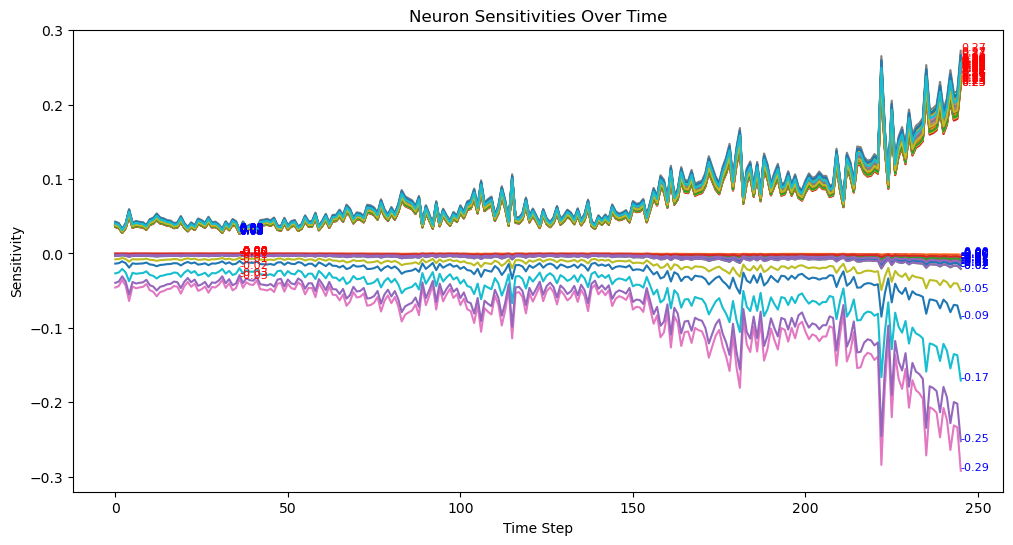

In [39]:
# Extract sensitivity data for neurons (excluding the intercept)
neuron_sensitivities = lpd_matrix.drop(columns=["Intercept"])

neuron_sensitivities = neuron_sensitivities.map(lambda x: x[0] if isinstance(x, list) else x)

# Plot each neuron's sensitivity over time
plt.figure(figsize=(12, 6))
for neuron in neuron_sensitivities.columns:
    plt.plot(neuron_sensitivities.index, neuron_sensitivities[neuron], label=neuron)

    # Get the highest and lowest sensitivity values
    max_idx = neuron_sensitivities[neuron].idxmax()
    min_idx = neuron_sensitivities[neuron].idxmin()
    max_val = neuron_sensitivities[neuron].max()
    min_val = neuron_sensitivities[neuron].min()
    
    # Add labels for the highest and lowest points
    plt.text(max_idx, max_val, f"{max_val:.2f}", color="red", fontsize=8)
    plt.text(min_idx, min_val, f"{min_val:.2f}", color="blue", fontsize=8)

# Customize the plot
plt.title("Neuron Sensitivities Over Time")
plt.xlabel("Time Step")
plt.ylabel("Sensitivity")

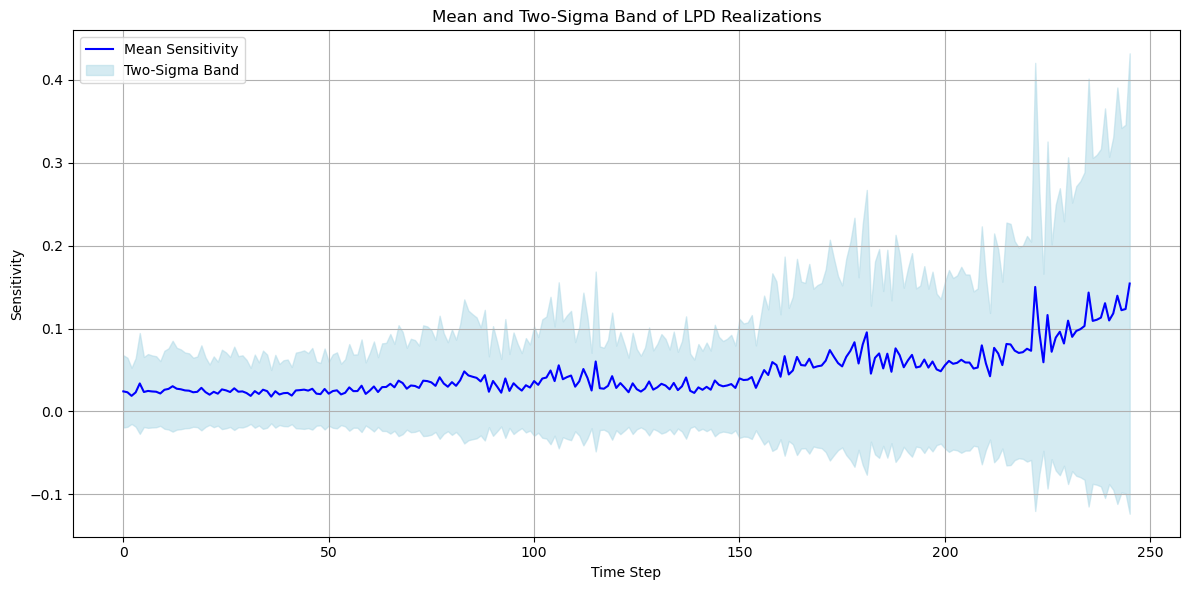

In [41]:
# Calculate mean and two-sigma band for neuron sensitivities
mean_sensitivity = neuron_sensitivities.mean(axis=1)
std_sensitivity = neuron_sensitivities.std(axis=1)

upper_band = mean_sensitivity + 2 * std_sensitivity
lower_band = mean_sensitivity - 2 * std_sensitivity

# Plot the mean and two-sigma band
plt.figure(figsize=(12, 6))

# Plot mean sensitivity
plt.plot(mean_sensitivity.index, mean_sensitivity, label="Mean Sensitivity", color="blue")

# Plot two-sigma band
plt.fill_between(
    mean_sensitivity.index,
    lower_band,
    upper_band,
    color="lightblue",
    alpha=0.5,
    label="Two-Sigma Band"
)

# Customize the plot
plt.title("Mean and Two-Sigma Band of LPD Realizations")
plt.xlabel("Time Step")
plt.ylabel("Sensitivity")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

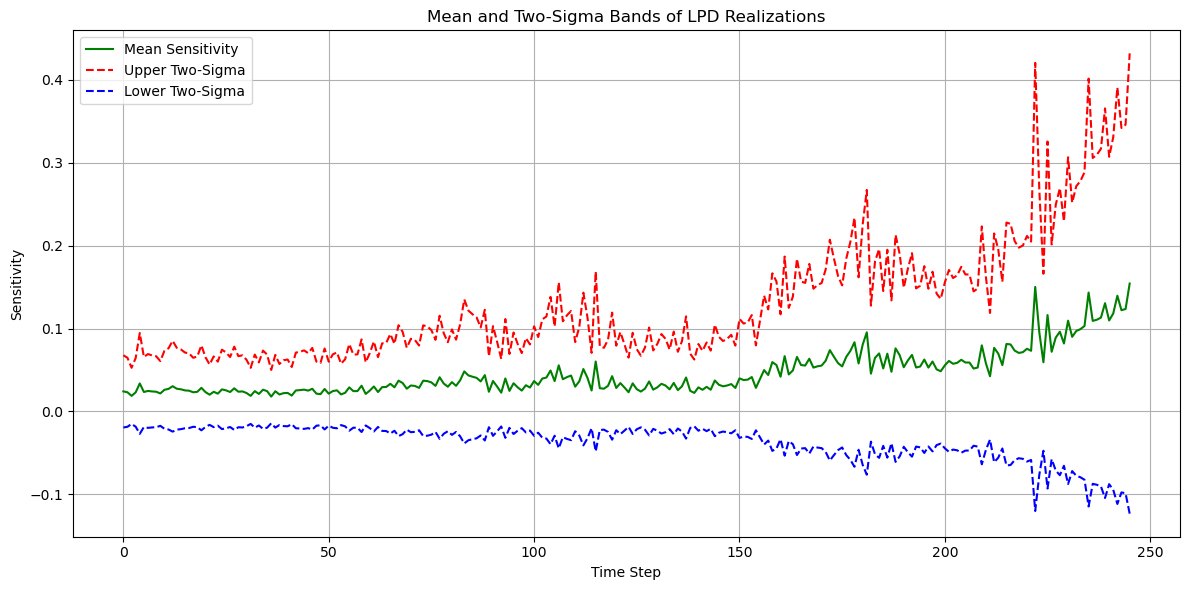

In [43]:
plt.figure(figsize=(12, 6))

# Plot mean sensitivity
plt.plot(mean_sensitivity.index, mean_sensitivity, label="Mean Sensitivity", color="green", linestyle="-")

# Plot upper two-sigma band
plt.plot(mean_sensitivity.index, upper_band, label="Upper Two-Sigma", color="red", linestyle="--")

# Plot lower two-sigma band
plt.plot(mean_sensitivity.index, lower_band, label="Lower Two-Sigma", color="blue", linestyle="--")

# Customize the plot
plt.title("Mean and Two-Sigma Bands of LPD Realizations")
plt.xlabel("Time Step")
plt.ylabel("Sensitivity")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In the context of Linear Parameter Data (LPD), the positive and negative sensitivities are a result of the relationship between input features (neurons) and the output at specific points in time. Here's why sensitivities can be both positive and negative:

**Positive Sensitivities:**
- Indicate that increasing the value of a specific input (neuron) increases the output. This happens when the partial derivative of the output with respect to the input is positive.

**Negative Sensitivities:**
- Indicate that increasing the value of a specific input (neuron) decreases the output. This happens when the partial derivative of the output with respect to the input is negative.

Potential research directions we could take from here:

1. More research into the area of "improving"/altering the current NN model to implement harder to comprehend structures, like more hidden layers, neurons, etc. to potentially improve the predictive accuracy while also being able to explain potential harder sensitivities that are more all over the place.
2. We could look into the area 
